In [1]:
import pandas as pd
import os

In [2]:
!pwd
!ls -la

/Users/maxburger/code/MadMax1995bb/powder_alert2.0/notebooks
total 864
drwxr-xr-x   8 maxburger  staff     256 Dec 10 11:50 .
drwxr-xr-x  18 maxburger  staff     576 Dec 10 11:34 ..
-rw-r--r--   1 maxburger  staff       0 Dec 10 08:36 .keep
-rw-r--r--   1 maxburger  staff  264154 Dec 10 11:50 Wisal_notebook.ipynb
-rw-r--r--   1 maxburger  staff   11202 Dec 10 11:50 alternative_notebook.ipynb
-rw-r--r--   1 maxburger  staff   59870 Dec 10 11:50 notebook_Anita-Gei_get_openmeteo_data.ipynb
-rw-r--r--   1 maxburger  staff   38604 Dec 10 11:50 notebook_Anita-Gei_model_tests.ipynb
-rw-r--r--   1 maxburger  staff   59870 Dec 10 09:27 notebook_MadMax1995bb.ipynb


In [10]:
current_dir = os.getcwd()
relative_path = os.path.dirname(current_dir)
file_name = "raw_data/historical_weather_openmeteo_01011979-08122024.csv"

file_path = os.path.join(relative_path, file_name)

df_hist_openmeteo = pd.read_csv(file_path)

In [11]:
df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'], infer_datetime_format=True)
#df_hist_openmeteo.set_index(['date'], inplace=True)

/var/folders/pb/bz16q8fx0flb7flbn8cbcsdw0000gn/T/ipykernel_72738/3396273356.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'], infer_datetime_format=True)


In [18]:
df_hist_openmeteo.head(3)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration
0,1979-01-01 00:00:00+00:00,-5.499,92.65972,-6.499,-9.440102,0.1,0.1,0.00,0.47,51.0,...,42.120000,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0
1,1979-01-01 01:00:00+00:00,-5.349,94.81615,-6.049,-9.425217,0.2,0.1,0.07,0.47,71.0,...,46.079998,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0
2,1979-01-01 02:00:00+00:00,-5.449,95.53807,-6.049,-9.401998,0.5,0.1,0.28,0.47,73.0,...,48.600000,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0


In [12]:
df_hist_openmeteo.dtypes

date                             datetime64[ns, UTC]
temperature_2m                               float64
relative_humidity_2m                         float64
dew_point_2m                                 float64
apparent_temperature                         float64
precipitation                                float64
rain                                         float64
snowfall                                     float64
snow_depth                                   float64
weather_code                                 float64
pressure_msl                                 float64
surface_pressure                             float64
cloud_cover                                  float64
cloud_cover_low                              float64
cloud_cover_mid                              float64
cloud_cover_high                             float64
et0_fao_evapotranspiration                   float64
vapour_pressure_deficit                      float64
wind_speed_10m                               f

In [13]:
from darts import TimeSeries

In [ ]:
df_hist_openmeteo['date'] = df_hist_openmeteo['date'].dt.tz_localize(None)

In [ ]:
series = TimeSeries.from_dataframe(df_hist_openmeteo, "date", "snowfall")

In [24]:
print(df_hist_openmeteo['date'].dtype)

datetime64[ns]


In [27]:
y = df_hist_openmeteo['snowfall']
X = df_hist_openmeteo.drop(columns='snowfall')

<Axes: >

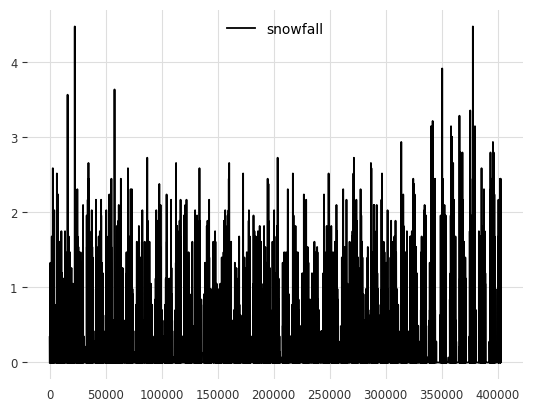

In [29]:
df_hist_openmeteo.plot(y='snowfall')